***Gett, previously known as `GetTaxi`***, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

Step 1: Understand the Data
Two datasets:


*   **`data_orders`**: Contains information about each order and its status (whether it was completed or failed), cancellation times, order times, etc.


*   **`data_offers`**: Contains information about the offers made to the orders (which can help to identify failed offers).




In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Load datasets
data_orders = pd.read_csv('/content/data_orders.csv')
data_offers = pd.read_csv('/content/data_offers.csv')

In [3]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [4]:
data_orders.shape

(10716, 8)

In [5]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [6]:
data_offers.shape

(334363, 2)

The data_offers data set is a simple map with 2 columns:

*   `order_gk` - order number, associated with the same column from the orders data set

*   `offer_id` - ID of an offer

To merge these two data sets for our task, we will do an **inner** join because we have multiple `offer_id` for each `order_gk`, and we want to have all the offers.





In [35]:
merged_data = data_orders.merge(right=data_offers, how="inner", on="order_gk")
merged_data.shape

(31268, 9)

In [27]:
merged_data.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In [36]:
merged_data["is_driver_assigned"] = np.where(merged_data["is_driver_assigned_key"] == 1, "Yes", "No")
merged_data["order_status"] = np.where(merged_data["order_status_key"] == 4, "Client Cancelled", "System Reject")

##Question 1

Build up a distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?



In [37]:
merged_data.groupby(by= ['is_driver_assigned', 'order_status'])['order_gk'].count().unstack()

order_status,Client Cancelled,System Reject
is_driver_assigned,,
No,13435,9469
Yes,8360,4


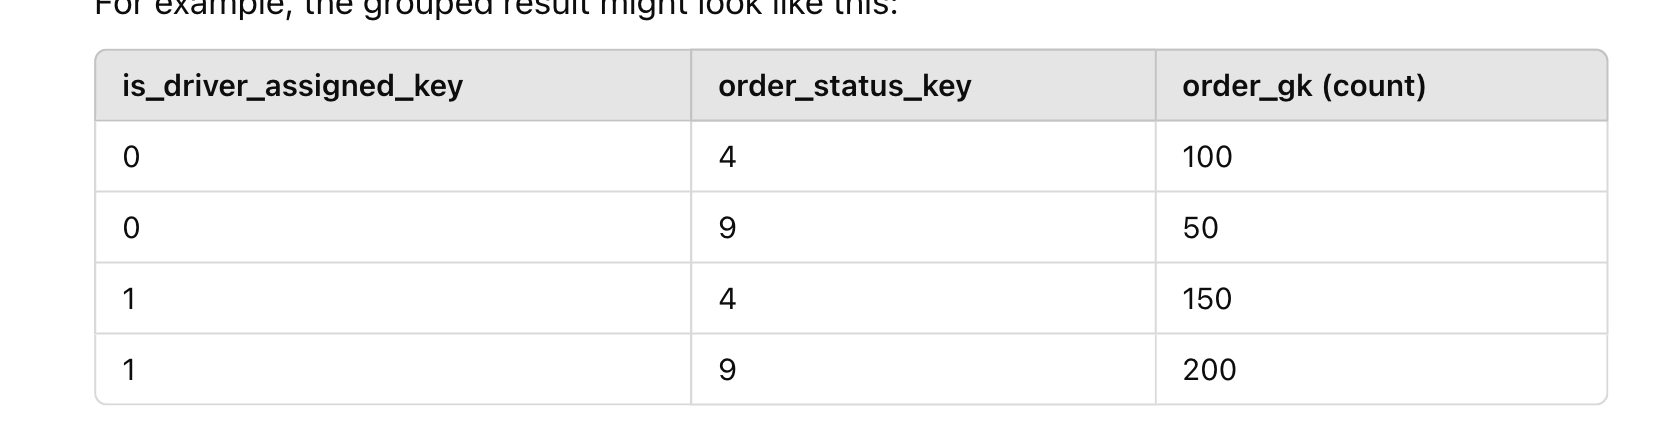

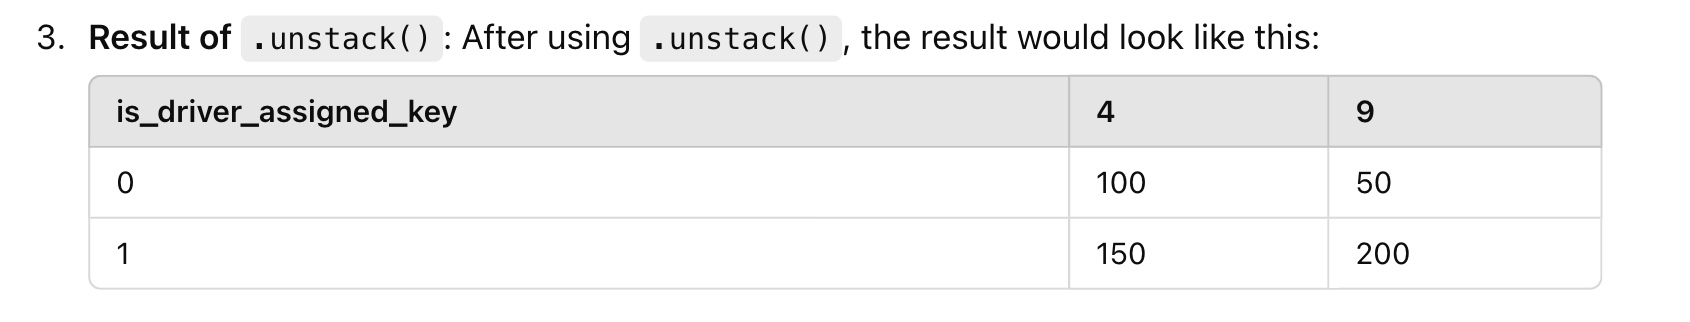

I noticed a significant number of orders canceled before a driver was assigned, which suggests that customers may have waited too long and opted for other transportation options.**13,435** orders were canceled by the client, while **9,469** were rejected by the system.There are **8,360** client cancellations after a driver was assigned, with only **4** orders being rejected by the system for an unknown reason.

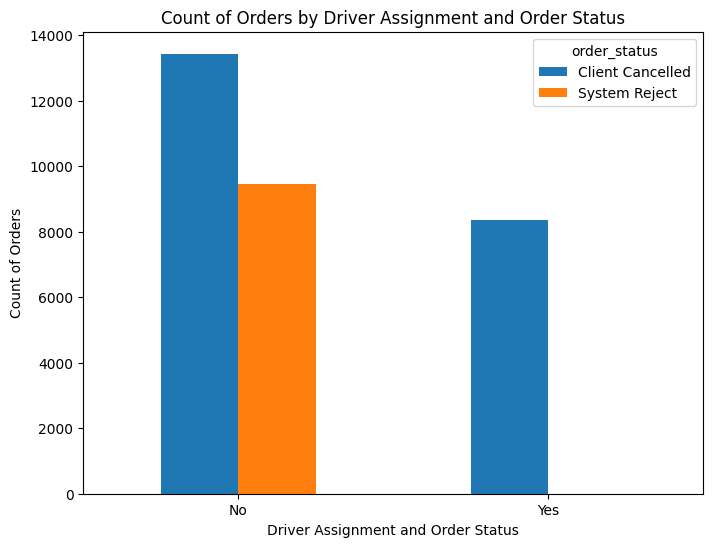

In [38]:
grouped_data = merged_data.groupby(by=['is_driver_assigned', 'order_status'])['order_gk'].count().unstack()

ax = grouped_data.plot(kind='bar', figsize=(8, 6), stacked=False)
# Set plot labels and title
ax.set_xlabel('Driver Assignment and Order Status')
ax.set_ylabel('Count of Orders')
ax.set_title('Count of Orders by Driver Assignment and Order Status')

# Set the x-axis labels to be more readable
ax.set_xticklabels(grouped_data.index, rotation=0)

# Show the plot
plt.show()


##Question 2

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [39]:
# Convert order_datetime to datetime
merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])

# Extract the hour from the order datetime
merged_data['order_hour'] = merged_data['order_datetime'].dt.hour

merged_data.head()

<ipython-input-39-db6639b8d74f>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['order_datetime'] = pd.to_datetime(merged_data['order_datetime'])


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
0,2025-03-10 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403,Yes,Client Cancelled,18
1,2025-03-10 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179,No,Client Cancelled,20
2,2025-03-10 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174,No,Client Cancelled,20
3,2025-03-10 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180,No,Client Cancelled,20
4,2025-03-10 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275,Yes,Client Cancelled,12


<Axes: title={'center': 'Count of Failed Orders by Order Hour'}, xlabel='order_hour'>

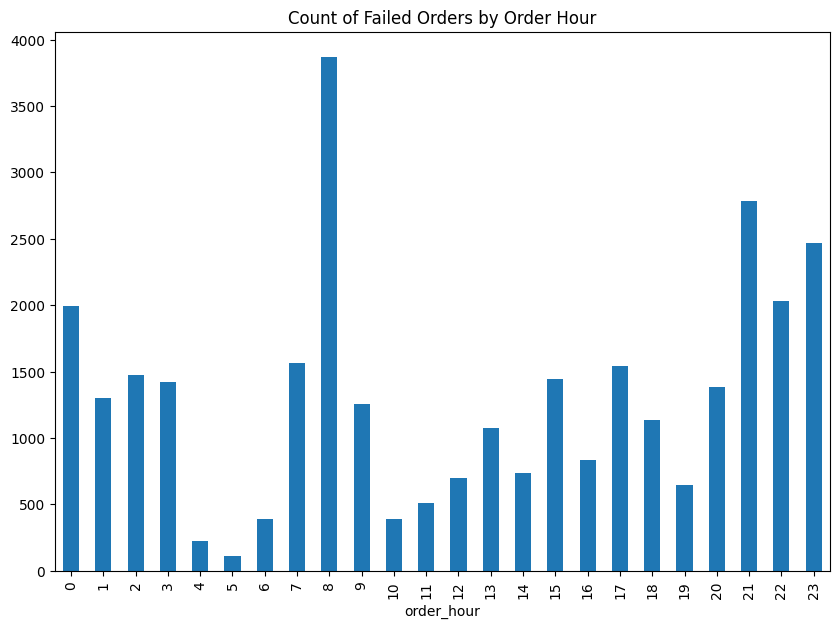

In [42]:
#create a bar plot to count the failed orders
data_to_plot = merged_data.groupby(by=['order_hour'])['order_gk'].count()
data_to_plot.plot(kind='bar' , figsize=(10, 7),  xticks=range(0, 24),
                                                         title="Count of Failed Orders by Order Hour")

Now, let's break down the reasons for failure into categories and analyze their trends to uncover any patterns or insights.

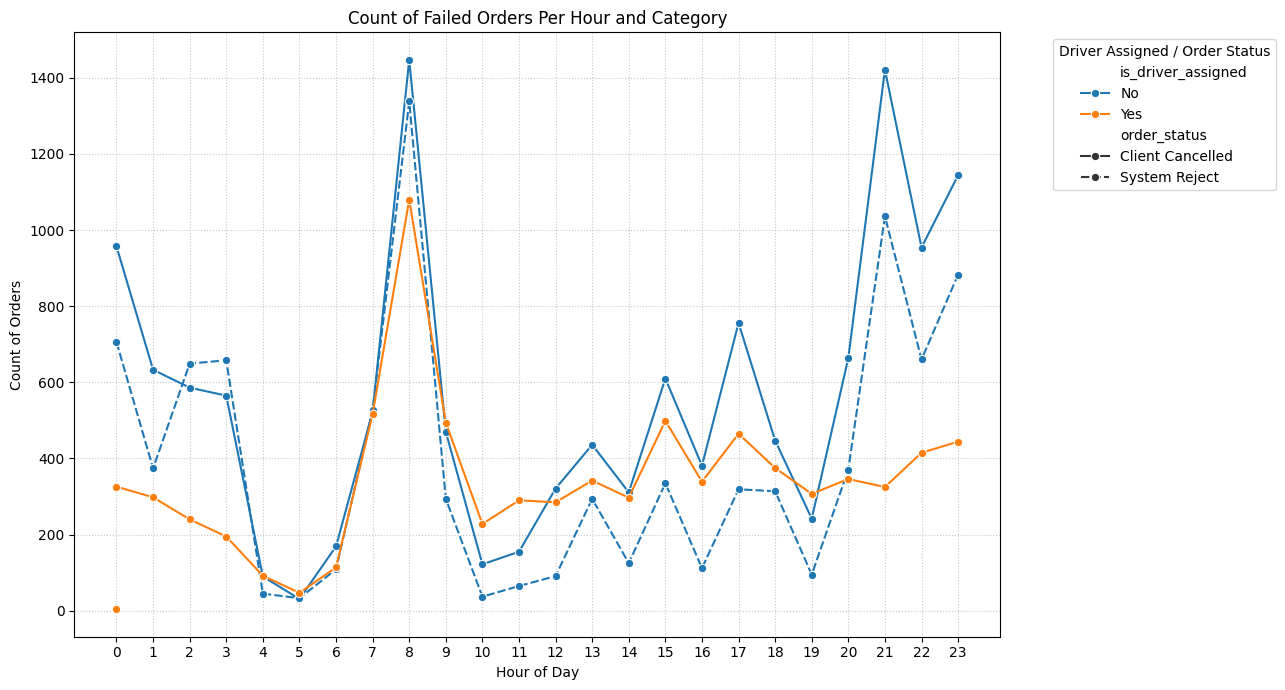

In [66]:
# Group by hour, driver assignment, and order status
grouped_q2 = merged_data.groupby(["order_hour", "is_driver_assigned", "order_status"])["order_gk"].count()
grouped_q2_df = grouped_q2.reset_index()
# Create the plot
plt.figure(figsize=(13, 7))

sns.lineplot(
    data=grouped_q2_df,
    x='order_hour',
    y='order_gk',
    hue='is_driver_assigned',
    style='order_status',
    marker='o'
)
# Add plot details
plt.title("Count of Failed Orders Per Hour and Category")
plt.xlabel("Hour of Day")
plt.ylabel("Count of Orders")
plt.xticks(range(0, 24))
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(title='Driver Assigned / Order Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


The four system rejections with an assigned driver primarily occurred around midnight (as shown in the grouped DataFrame output). The other categories exhibit a similar distribution, except for client cancellations with an assigned driver, which are noticeably lower during nighttime hours.

##Question 3

Plot the average time to cancellation with and without driver, by hour. Can we draw any conclusions from this plot?

In [49]:
grouped_q3 = merged_data.groupby(by= ['order_hour' , 'is_driver_assigned'])['cancellations_time_in_seconds'].mean()

In [54]:
grouped_q3

order_hour  is_driver_assigned
0           No                    115.126437
            Yes                   276.082822
1           No                    100.593997
            Yes                   296.312081
2           No                    121.305461
            Yes                   301.466667
3           No                    129.182301
            Yes                   368.682051
4           No                    100.733333
            Yes                   245.250000
5           No                    102.838710
            Yes                   156.617021
6           No                    202.952663
            Yes                   225.508772
7           No                    141.177820
            Yes                   177.640232
8           No                    132.625432
            Yes                   172.896296
9           No                    138.014894
            Yes                   230.821862
10          No                     93.795082
            Yes                   206.447368
11          No                     93.090323
            Yes                   276.793103
12          No                    128.224299
            Yes                   243.000000
13          No                    103.577982
            Yes                   248.301170
14          No                    112.752412
            Yes                   241.367003
15          No                    140.970492
            Yes                   188.380762
16          No                    123.181102
            Yes                   217.126844
17          No                    106.842593
            Yes                   280.782796
18          No                     85.845638
            Yes                   270.277333
19          No                    103.231405
            Yes                   151.039088
20          No                    117.518072
            Yes                   214.517341
21          No                    130.828290
            Yes                   224.443077
22          No                    103.662474
            Yes                   230.720482
23          No                    117.294580
            Yes                   320.189189
Name: cancellations_time_in_seconds, dtype: float64

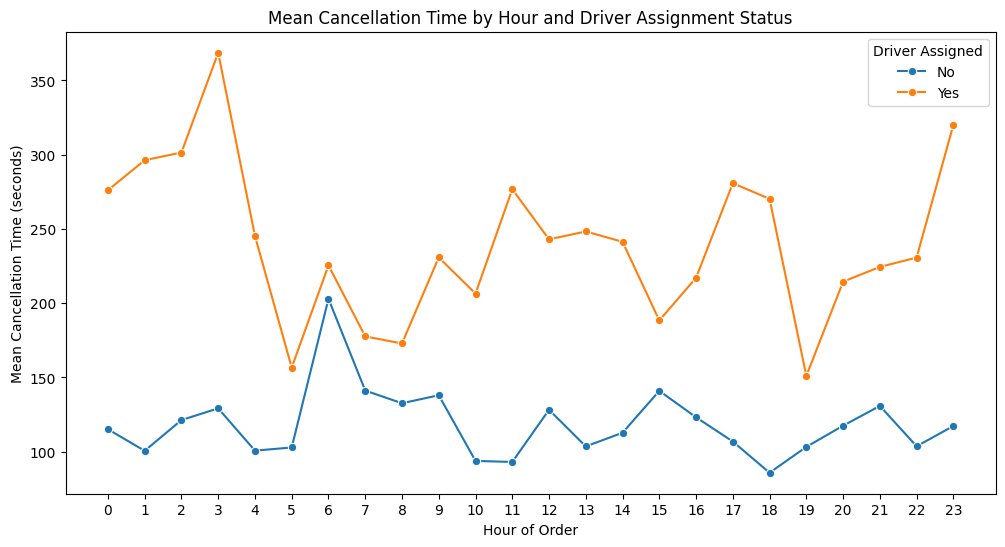

In [59]:
# Reset index to convert the grouped data to a DataFrame
grouped_q3_df = grouped_q3.reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_q3_df,
    x='order_hour',
    y='cancellations_time_in_seconds',
    hue='is_driver_assigned',
    marker='o'
)

# Customize the plot
plt.title('Mean Cancellation Time by Hour and Driver Assignment Status')
plt.xlabel('Hour of Order')
plt.ylabel('Mean Cancellation Time (seconds)')
plt.xticks(range(0, 24))  # Assuming hours are 0-23
plt.legend(title='Driver Assigned')

# Show the plot
plt.show()

The average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.


##Question 4

Plot the distribution of average ETA by hours. How can this plot be explained?



In [69]:
df_plot = merged_data.groupby(by=['order_hour'])['m_order_eta'].mean()

<Axes: title={'center': 'Avg. ETA by hours'}, xlabel='order_hour'>

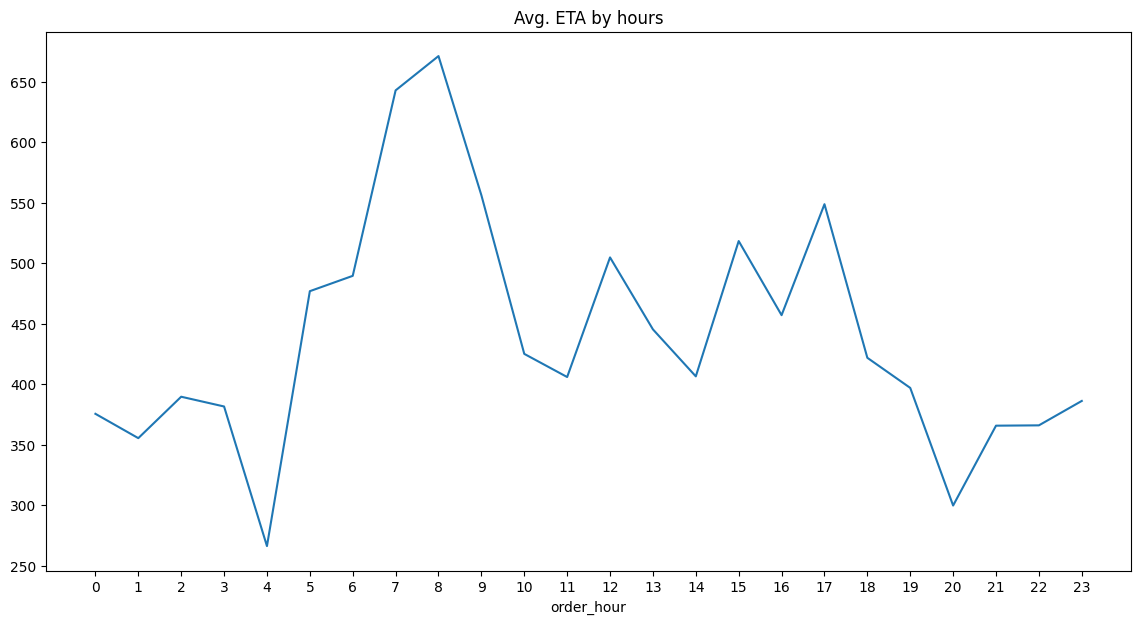

In [74]:
df_plot.plot(figsize=(14, 7),xticks=range(0, 24), title= 'Avg. ETA by hours')

##New Study - Question 5

Using the h3 and folium packages, calculate how many size 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [76]:
pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00


In [77]:
import h3
import folium

This code uses the H3 library, a geospatial indexing system developed by Uber. H3 divides the earth into **hexagonal** cells of different sizes (resolutions).
What it's doing:

For each row in the dataframe, it converts the geographic coordinates (latitude and longitude) into an H3 hexagon ID at resolution 8
Resolution 8 creates hexagons approximately 0.74 km² in area
The result is stored in a new column called "hex_id"

Why we use H3:

It enables efficient spatial analysis and binning of geographic data
The hexagonal grid eliminates distortion issues found in rectangular grids
H3 makes it easy to aggregate data points within the same area
It's particularly useful for analyzing ride-sharing, delivery, or any location-based service data
The hierarchical nature of H3 allows for flexible aggregation at different spatial scales

In [81]:
merged_data["hex_id"] = merged_data.apply(
    func=lambda row: h3.latlng_to_cell(lat=row["origin_latitude"], lng=row["origin_longitude"], res=8), axis=1)

In [82]:
grouped_q5 = merged_data.groupby(by="hex_id")["order_gk"].count()
grouped_q5.shape

(139,)

In [84]:
grouped_q5 = grouped_q5.reset_index()
grouped_q5.sample(n=5, random_state=42)

,index,hex_id,order_gk
135,135,88195d74d1fffff,1
66,66,88195d2a33fffff,12
31,31,88195d2941fffff,52
118,118,88195d2b5dfffff,31
42,42,88195d2961fffff,5


To find the number of hexes that contain 80% of the orders, we will apply a cumulative percentage operation over the `order_gk` count column in the `grouped_q5` DataFrame. This consists of the following steps:



In [85]:
#sort the data by count
grouped_q5 = grouped_q5.sort_values(by="order_gk")

1.Find the total number (sum) of failed orders.
2.Apply the method cumsum to find the cumulative sum of the order-count column.
3.Divide by the total sum to generate percentages.
4.Filter to find the row that is closest to 80%.

In [86]:
total_orders = grouped_q5["order_gk"].sum()
grouped_q5["cum_sum"] = grouped_q5["order_gk"].cumsum()
grouped_q5["cum_perc"] = 100 * grouped_q5["cum_sum"] / total_orders
grouped_q5[grouped_q5["cum_perc"] <= 80]

,index,hex_id,order_gk,cum_sum,cum_perc
137,137,88195d74d5fffff,1,1,0.003198
135,135,88195d74d1fffff,1,2,0.006396
79,79,88195d2aebfffff,1,3,0.009594
11,11,88195d282bfffff,1,4,0.012793
122,122,88195d3993fffff,1,5,0.015991
...,...,...,...,...,...
61,61,88195d2a27fffff,1295,15628,49.980811
20,20,88195d284dfffff,1937,17565,56.175643
91,91,88195d2b19fffff,1960,19525,62.444032
87,87,88195d2b11fffff,2191,21716,69.451196


In [100]:
map = folium.Map(location=[merged_data["origin_latitude"].mean(), merged_data["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")

In [90]:
pip install geojson

In [ ]:
import json
import geojson

In [101]:
def to_geojson(row):
    """Transform hex_id into a geojson object with error checking."""
    try:
        # Get the boundary coordinates
        boundary = h3.cell_to_boundary(h=row["hex_id"])

        # H3 returns coordinates as [lat, lng], but GeoJSON expects [lng, lat]
        # Let's swap the coordinates
        boundary = [[coord[1], coord[0]] for coord in boundary]

        geometry = {
            "type": "Polygon",
            "coordinates": [boundary]
        }
        return geojson.Feature(
            id=row["hex_id"],
            geometry=geometry,
            properties={"order_gk": float(row["order_gk"])}  # Ensure the value is float
        )
    except Exception as e:
        print(f"Error processing hex_id {row['hex_id']}: {e}")
        return None

In [104]:
import branca.colormap

In [102]:
import matplotlib

# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = grouped_q5["order_gk"].max()
min_order_gk = grouped_q5["order_gk"].min()

<ipython-input-102-8cc6e9cd18ed>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap(name="plasma")


In [105]:

# Create GeoJSON features with error handling
geojsons = [feature for feature in grouped_q5.apply(func=to_geojson, axis=1).values.tolist() if feature is not None]

# Convert to GeoJSON string with indent for readability
geojson_str = json.dumps(geojson.FeatureCollection(geojsons), indent=2)

# Add GeoJSON to map with modified style function
folium.GeoJson(
    data=geojson_str,
    style_function=lambda f: {
        "fillColor": matplotlib.colors.to_hex(
            colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))
        ),
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["order_gk"],
        aliases=["Order Count:"],
        style="background-color: white; color: black; font-family: arial; font-size: 12px; padding: 10px;"
    )
).add_to(map)

# Add a colormap legend
#Change cm.LinearColormap to matplotlib.colors.LinearSegmentedColormap
# the colormap object created earlier is used here.
#Remove the reassignment of colormap.
colormap_legend = matplotlib.colors.LinearSegmentedColormap.from_list(
    'CustomMap',
    [matplotlib.colors.to_hex(colormap(i)) for i in np.linspace(0, 1, 8)],
    N=8,
)

#Create a color scale object from branca library
color_scale = branca.colormap.LinearColormap(
    colors=[matplotlib.colors.to_hex(colormap(i)) for i in np.linspace(0, 1, 8)],
    vmin=min_order_gk,
    vmax=max_order_gk,
    caption='Number of Orders'
)

map.add_child(color_scale)

map.save('order_density_map.html')
print("Please open map.html in a web browser to view the visualization.")




Please open map.html in a web browser to view the visualization.
